In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#imports for splitting data and imputing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#importying .py file for testing
import wrangle_zillow as wz
import wrangle_mall as wm

### 1. Acquire Data from SQL Server

In [2]:
# Create SQL query
## Included class solution as alternate

query = '''
SELECT * FROM properties_2017 AS prop
JOIN (SELECT parcelid, MAX(transactiondate) AS transactiondate FROM predictions_2017 GROUP BY parcelid) AS trans ON prop.parcelid = trans.parcelid
JOIN predictions_2017 AS pred ON prop.parcelid = pred.parcelid AND pred.transactiondate = trans.transactiondate 
LEFT JOIN airconditioningtype USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN storytype USING (storytypeid)
LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL 
AND prop.longitude IS NOT NULL
AND YEAR(pred.transactiondate) = 2017;

'''

alternate = '''
SELECT
    prop.*,
    predictions_2017.logerror,
    predictions_2017.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
    FROM predictions_2017
    GROUP BY parcelid
) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                      AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
LEFT JOIN storytype story USING (storytypeid)
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL
  AND prop.longitude IS NOT NULL
  AND transactiondate <= '2017-12-31';
'''

df = pd.read_sql(alternate, get_db_url('zillow'))
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None


### 2. Summarize data

In [3]:
df.shape

(77380, 68)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77184 non-null  float64
 13  f

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77380.0,1.495126e+06,8.609057e+05,3.490000e+02,7.520500e+05,1.497870e+06,2.240480e+06,2.982274e+06
parcelid,77380.0,1.300715e+07,3.481368e+06,1.071186e+07,1.153830e+07,1.253155e+07,1.421184e+07,1.676893e+08
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77380.0,2.299134e+00,9.966566e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77380.0,3.053489e+00,1.139103e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49671.0,6.534638e+00,1.721933e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76771.0,2.316871e+00,9.797606e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [6]:
len(df)

77380

### 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [7]:
def attribute_nulls(df):
    nulls = df.isnull().sum()
    rows = len(df)
    percent_missing = nulls / rows 
    dataframe = pd.DataFrame({'rows_missing': nulls, 'percent_missing': percent_missing})
    return dataframe
    

In [8]:
attribute_nulls(df)

,rows_missing,percent_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52427,0.677526
architecturalstyletypeid,77174,0.997338
basementsqft,77330,0.999354
...,...,...
buildingclassdesc,77365,0.999806
heatingorsystemdesc,27941,0.361088
propertylandusedesc,0,0.000000
storydesc,77330,0.999354


Takeaways:
- Several attributes have almost all values missing such as building class desc, storydesc, etc. I will want to drop these attributes entirely.
- I will drop attributes that are missing more than 30% of values. 
- I'll drop unnecessary or duplicated id columns.

### 4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [9]:
def column_nulls(df):
    new_df = pd.DataFrame(df.isnull().sum(axis=1), columns = ['cols_missing']).reset_index()\
    .groupby('cols_missing').count().reset_index().\
    rename(columns = {'index': 'rows'})
    new_df['percent_missing'] = new_df.cols_missing/df.shape[1]
    return new_df

In [10]:
column_nulls(df)

,cols_missing,rows,percent_missing
0,23,2,0.338235
1,24,13,0.352941
2,25,24,0.367647
3,26,65,0.382353
4,27,316,0.397059
5,28,455,0.411765
6,29,5270,0.426471
7,30,3455,0.441176
8,31,9891,0.455882
9,32,12579,0.470588


## Prepare 

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.


In [11]:
# Checking my current data shape before removing properties
df.shape

(77380, 68)

Based on the propertylandusetype table, I am choosing the following landusetypeid's as corresponding to single unit properties: 

[261, 262, 263, 264, 266, 268, 273, 276, 279]

In [12]:
# Re-assign data frame to only include the single unit properties
single_unit = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_unit)]

In [13]:
# Checking the new shape after removals
df.shape

(71693, 68)

In [14]:
# Write a function to replicate this work
def get_single_units(df):
    single_unit = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_unit)]
    return df
    

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [15]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [16]:
df = handle_missing_values(df)
df.shape

(71544, 34)

In [17]:
nulls = attribute_nulls(df)
nulls.sort_values('percent_missing', ascending = False)

,rows_missing,percent_missing
buildingqualitytypeid,26595,0.371729
unitcnt,26222,0.366516
propertyzoningdesc,26209,0.366334
heatingorsystemdesc,24984,0.349212
heatingorsystemtypeid,24984,0.349212
lotsizesquarefeet,8048,0.112490
regionidcity,1320,0.018450
censustractandblock,207,0.002893
finishedsquarefeet12,189,0.002642
structuretaxvaluedollarcnt,77,0.001076


3. Decide how to handle the remaining missing values:

Fill with constant value.
Impute with mean, median, mode.
Drop row/column

In [18]:
## Splitting data before imputing
# train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [19]:
# Imputing columns with mean

columns = [
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet12',
    'structuretaxvaluedollarcnt',
    'taxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
]

imputer = SimpleImputer(strategy = 'mean')
imputer.fit(train[columns])

train[columns] = imputer.transform(train[columns])
validate[columns] = imputer.transform(validate[columns])
test[columns] = imputer.transform(test[columns])

In [20]:
# Imputing columns with mode
columns = [
    'calculatedbathnbr',
    'fullbathcnt',
    'regionidcity',
    'regionidzip',
    'yearbuilt'
]

imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(train[columns])

train[columns] = imputer.transform(train[columns])
validate[columns] = imputer.transform(validate[columns])
test[columns] = imputer.transform(test[columns])

In [21]:
#Imputing with median 
columns = [
    'censustractandblock'
]

imputer = SimpleImputer(strategy = 'median')
imputer.fit(train[columns])

train[columns] = imputer.transform(train[columns])
validate[columns] = imputer.transform(validate[columns])
test[columns] = imputer.transform(test[columns])

In [22]:
# Function to replicate this work

def impute_missing_values(df, columns_strategy):
    train, validate, test = split_data(df)
    
    for strategy, columns in columns_strategy.items():
        imputer = SimpleImputer(strategy = strategy)
        imputer.fit(train[columns])

        train[columns] = imputer.transform(train[columns])
        validate[columns] = imputer.transform(validate[columns])
        test[columns] = imputer.transform(test[columns])
        
    return train, validate, test

## Mall Customers Data

1. Acquire data from mall_customers.customers in mysql database.

In [23]:
df = wm.get_mall()
df.head()

Using cached csv...


,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


2. Summarize data (include distributions and descriptive statistics).

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [25]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [26]:
cols = ['gender', 'age', 'annual_income', 'spending_score']

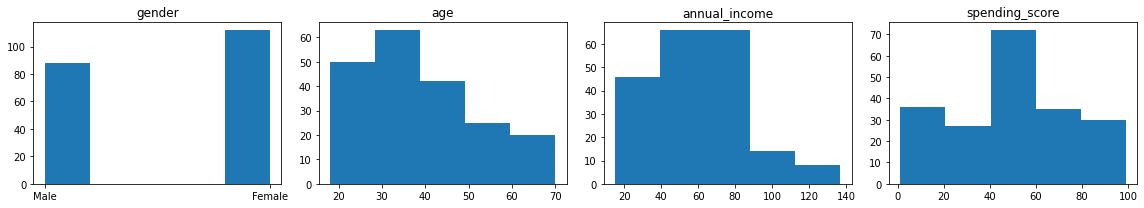

In [27]:
# Get distributions
wm.get_hists(df, cols)

3. Detect outliers using IQR.

In [28]:
wm.get_upper_outliers(df.annual_income, 1.5)

0      0.00
1      0.00
2      0.00
3      0.00
4      0.00
       ... 
195    0.00
196    0.00
197    0.00
198    4.25
199    4.25
Name: annual_income, Length: 200, dtype: float64

In [29]:
wm.get_lower_outliers(df.annual_income, 1.5)

0      0
1      0
2      0
3      0
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: annual_income, Length: 200, dtype: int64

4. Split data (train, validate, and test split).

In [30]:
train, validate, test = wm.split_data(df)
train.shape, validate.shape, test.shape

((112, 5), (48, 5), (40, 5))

5. Encode categorical columns using a one hot encoder (pd.get_dummies).

In [31]:
cat_vars = ['gender']

train = wm.encode_categorical(train, cat_vars)
validate = wm.encode_categorical(validate, cat_vars)
test = wm.encode_categorical(test, cat_vars)

In [32]:
#sanity check
train.head()

,customer_id,age,annual_income,spending_score,gender_Male
123,124,39,69,91,1
76,77,45,54,53,0
171,172,28,87,75,1
10,11,67,19,14,1
35,36,21,33,81,0


6. Handles missing values.

In [33]:
train.isnull().sum()

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

In [34]:
validate.isnull().sum()

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

In [35]:
test.isnull().sum()

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

*There are no missing values to handle.*

7. Scaling

In [36]:
columns_to_scale = ['age', 'annual_income', 'spending_score']
train_scaled, validate_scaled, test_scaled = wm.scale_data(train, validate, test, columns_to_scale)

In [37]:
# sanity check
train_scaled.head()

,customer_id,age,annual_income,spending_score,gender_Male
123,124,0.403846,0.442623,0.957447,1
76,77,0.519231,0.319672,0.553191,0
171,172,0.192308,0.590164,0.787234,1
10,11,0.942308,0.032787,0.138298,1
35,36,0.057692,0.147541,0.851064,0
